# <center> InternAnalytics </center> #

### 1. Introduction ###
Objectif :
Le projet InternAnalytics a pour but d’analyser une base de données regroupant des offres d'emploi afin de tirer des insights exploitables pour :

- Comprendre les tendances du marché de l’emploi (secteurs les plus actifs, localisations recherchées, etc.).
- Identifier les facteurs d’attractivité des offres d’emploi (entreprises populaires, offres les plus vues).
- Évaluer les tendances salariales en fonction des secteurs, des localisations, et des postes proposés.
- Offrir des recommandations exploitables, par exemple :
    -  Aux chercheurs d’emploi : quels secteurs et localisations privilégier.
    - Aux recruteurs : comment optimiser leurs offres pour attirer plus de candidats.
- S’informer sur les offres d’alternance :
    - Identifier les entreprises qui proposent des contrats en alternance.
    - Analyser les postes et secteurs qui recrutent le plus en alternance.
    - Comprendre les salaires et avantages liés aux offres d’alternance.
- Champs disponibles : `job_id`, `company_name`, `title`, `description`, `max_salary`, `pay_period`, `location`, `company_id`, `views, med_salary`.

Ce projet vise donc à offrir une vision globale et spécifique des opportunités sur le marché, avec un focus particulier sur les alternances, pour mieux répondre aux besoins des étudiants et jeunes professionnels.


### 2. Chargement des données ###
- Importation des bibliothèques nécessaires (e.g., pandas, numpy, matplotlib, seaborn).
- Chargement du fichier de données (CSV, SQL, ou autre).
- Aperçu des données (df.head() et df.info()).

In [91]:
# Utility import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dataset import
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

# Advanced analyse import
import folium
from folium.plugins import HeatMap
from IPython.display import display
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [92]:
# Dowload dataset using kaggle API
path = os.getcwd().replace("notebooks", "kaggle.json")

with open(path, 'r') as file:
    kaggle_creds = json.load(file)

os.environ["KAGGLE_USERNAME"] = kaggle_creds["username"]
os.environ["KAGGLE_KEY"] = kaggle_creds["key"]

dataset_name = 'arshkon/linkedin-job-postings'
download_path = "../data/raw"
os.makedirs(download_path, exist_ok=True)

api = KaggleApi()
api.authenticate()
print("Téléchargement en cours...")
api.dataset_download_files(dataset_name, path=download_path, unzip=True)
print(f"Dataset téléchargé et extrait dans : {download_path}")

Téléchargement en cours...
Dataset URL: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings
Dataset téléchargé et extrait dans : ../data/raw


### 3. Nettoyage et Préparation des Données ###
- Détection des données manquantes : Vérifier les colonnes avec des valeurs NaN ou vides.
- Traitement des doublons : Vérifier et supprimer les entrées redondantes si nécessaire.
- Standardisation des colonnes : Par exemple, uniformiser les formats des - salaires (max_salary, med_salary) ou des localisations (location).
- Conversion des types de données pour faciliter l’analyse :
    - pay_period en fréquence (mensuel, annuel, etc.).
views en entier.
    - Extraction de catégories pertinentes à partir de description (ex : analyse des mots-clés).

In [103]:
# Charger les donnée dans un dataframe pandas 
data = pd.read_csv("../data/raw/postings.csv")

In [104]:
data_clean = data.drop_duplicates()
data_clean = data_clean.drop(columns=['med_salary', 'min_salary', 'max_salary', 'listed_time', 'posting_domain', 'original_listed_time', 'job_posting_url', 'expiry', 'closed_time', 'application_url' ,'sponsored', 'zip_code', 'fips', 'compensation_type'])

In [105]:
# cleans the dataset by handling missing values.

data_clean['remote_allowed'] = data_clean['remote_allowed'].fillna(0).astype(int)
data_clean['applies'] = data_clean['applies'].fillna(0).astype(int)
data_clean['normalized_salary'] = pd.to_numeric(data_clean['normalized_salary'], errors='coerce')
data_clean = data_clean.dropna(subset=['company_name'])
for elt in data_clean :
    data_clean[elt] = data_clean[elt].fillna('Not specified')


os.makedirs("../data/interim/", exist_ok=True)
data_clean.to_csv("../data/interim/posting_clean.csv", header=True)

In [44]:
data_clean.head()

,job_id,company_name,title,description,pay_period,location,company_id,views,formatted_work_type,applies,remote_allowed,application_type,formatted_experience_level,skills_desc,work_type,currency,normalized_salary
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,HOURLY,"Princeton, NJ",2774458.0,20.0,Full-time,2,0,ComplexOnsiteApply,Not specified,Requirements: \n\nWe are seeking a College or ...,FULL_TIME,USD,38480.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,YEARLY,"Cincinnati, OH",64896719.0,8.0,Full-time,0,0,ComplexOnsiteApply,Not specified,We are currently accepting resumes for FOH - A...,FULL_TIME,USD,55000.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,YEARLY,"New Hyde Park, NY",766262.0,16.0,Full-time,0,0,ComplexOnsiteApply,Not specified,This position requires a baseline understandin...,FULL_TIME,USD,157500.0
5,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,HOURLY,"Raleigh, NC",1481176.0,9.0,Internship,4,0,ComplexOnsiteApply,Not specified,Not specified,INTERNSHIP,USD,35360.0
6,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,YEARLY,United States,81942316.0,7.0,Contract,1,1,SimpleOnsiteApply,Not specified,Not specified,CONTRACT,USD,180000.0


### 4. Exploration des Données (EDA - Exploratory Data Analysis) ###
- Statistiques descriptives :
    - Distribution des salaires (max_salary, med_salary).
    - Entreprises avec le plus d’offres (company_name).
- Visualisation des données :
    - Histogrammes et boxplots pour les salaires.
    - Nuage de points pour corréler les salaires et les vues.
    - Graphiques géographiques pour la localisation des offres (location).
- Analyse des tendances :
    - Tendances par secteur (basé sur les mots-clés dans title ou description).
    - Entreprises les plus attractives (basé sur views).

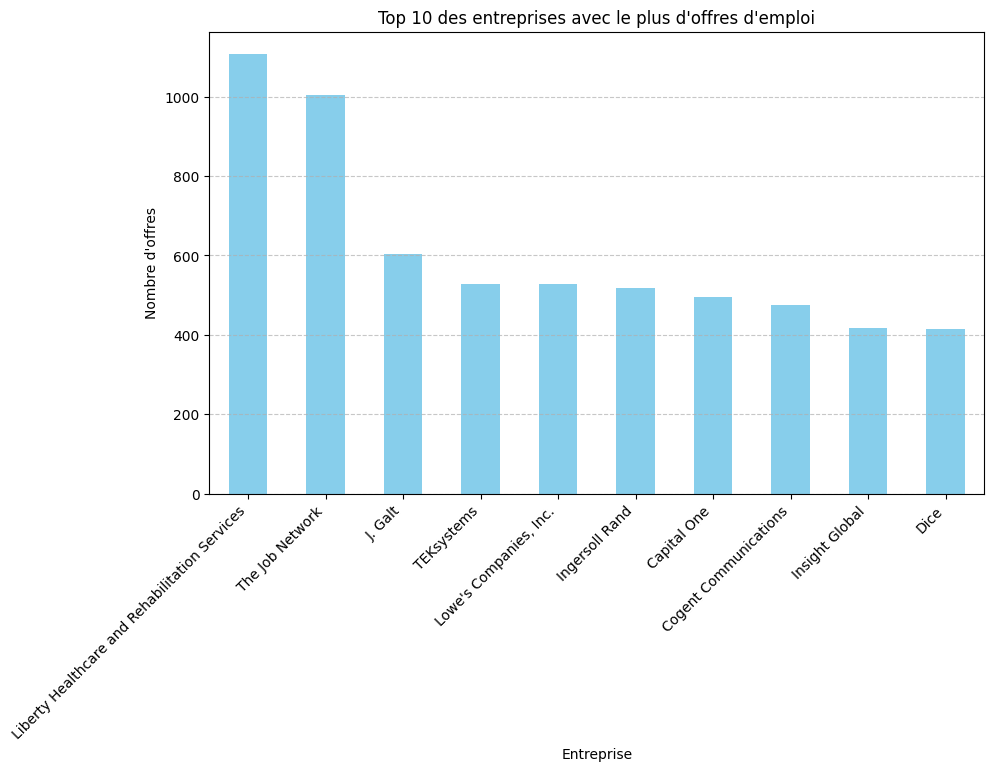

In [45]:
# Identify the top 10 companies with the most job postings and visualize the data with a bar chart

top_companies = data_clean['company_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_companies.plot(kind='bar', color='skyblue')
plt.title("Top 10 des entreprises avec le plus d'offres d'emploi")
plt.xlabel("Entreprise")
plt.ylabel("Nombre d'offres")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

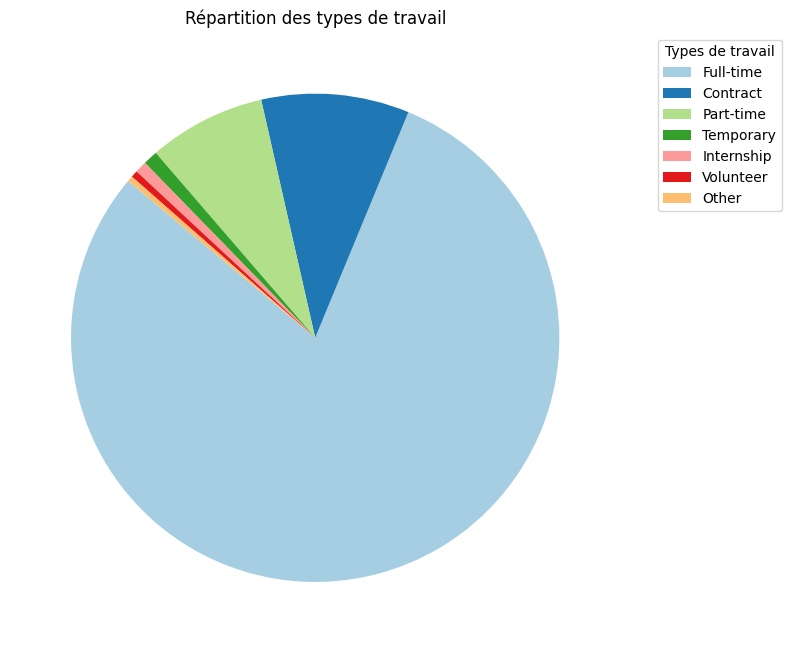

In [46]:
# Visualize the distribution of work types in the dataset using a pie chart

work_type_counts = data_clean['formatted_work_type'].value_counts()

plt.figure(figsize=(8, 8))
colors = plt.cm.Paired.colors
work_type_counts.plot(
    kind='pie',
    startangle=140,
    colors=colors,
    labels=None 
)

plt.legend(work_type_counts.index, title="Types de travail", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Répartition des types de travail")
plt.ylabel("")
plt.tight_layout()
plt.show()


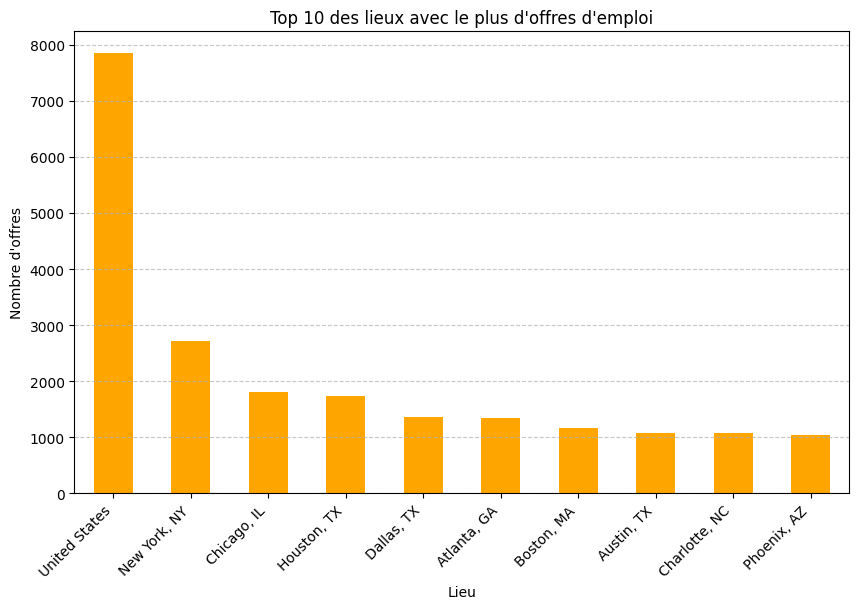

In [53]:
# Identify the top 10 locations with the most job postings and visualize the data

top_locations = data_clean['location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='orange')
plt.title("Top 10 des lieux avec le plus d'offres d'emploi")
plt.xlabel("Lieu")
plt.ylabel("Nombre d'offres")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

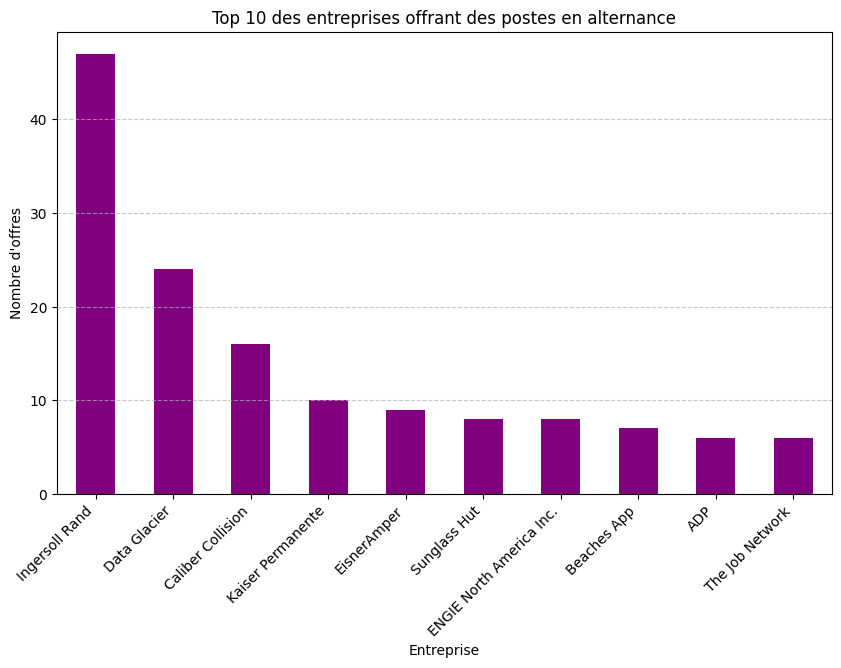

In [50]:
# Filter the dataset for internship-related job postings and visualize the top 10 companies offering internships

alternance_data = data_clean[data_clean['work_type'].str.contains('Internship', na=False, case=False)]
alternance_counts = alternance_data['company_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
alternance_counts.plot(kind='bar', color='purple')
plt.title("Top 10 des entreprises offrant des postes en alternance")
plt.xlabel("Entreprise")
plt.ylabel("Nombre d'offres")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

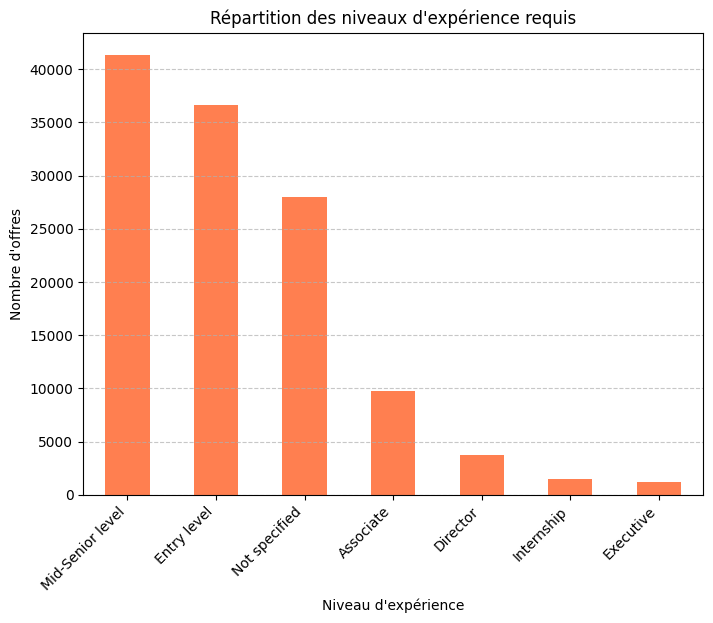

In [51]:
# Visualize the distribution of required experience levels in the dataset

experience_counts = data_clean['formatted_experience_level'].value_counts()

plt.figure(figsize=(8, 6))
experience_counts.plot(kind='bar', color='coral')
plt.title("Répartition des niveaux d'expérience requis")
plt.xlabel("Niveau d'expérience")
plt.ylabel("Nombre d'offres")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 5. Analyses Avancées et Insights ###

- Segmentation des données :
    - Comparaison des salaires par localisation.
    - Entreprises par secteur d’activité.
- Détection des relations et corrélations :
    - Corrélation entre views et max_salary.
    - Analyse des types d’emploi les plus attractifs (title, description).
- Suggestions basées sur les insights :
    - Quels types d’emplois attirer le plus de vues ?
    - Quels secteurs offrent les meilleurs salaires ?

In [109]:
# Retrieve geographic coordinates (latitude and longitude) for the first 1000 job locations

data_map = data_clean.head(1000)
geolocator = Nominatim(user_agent="geoapi")

def get_coordinates(location):
    try:
        geo = geolocator.geocode(location, timeout=10)
        if geo:
            return geo.latitude, geo.longitude
    except GeocoderTimedOut:
        return None, None
    return None, None

data_map[['latitude', 'longitude']] = data_map['location'].apply(
    lambda loc: pd.Series(get_coordinates(loc))
)

print(data_map[['location', 'latitude', 'longitude']])


                          location   latitude   longitude
0                    Princeton, NJ  40.349695  -74.659738
2                   Cincinnati, OH  39.101454  -84.512460
3                New Hyde Park, NY  40.735216  -73.688324
5                      Raleigh, NC  35.780398  -78.639099
6                    United States  39.783730 -100.445882
...                            ...        ...         ...
1089                   Oakland, CA  37.804456 -122.271356
1091                   Flowood, MS  32.309286  -90.138681
1092  Cincinnati Metropolitan Area        NaN         NaN
1093                Sugar Land, TX  29.619679  -95.634946
1094                  St Clair, MI  38.059294  -93.794546

[1000 rows x 3 columns]


/tmp/ipykernel_45645/3089664553.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_map[['latitude', 'longitude']] = data_map['location'].apply(
/tmp/ipykernel_45645/3089664553.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_map[['latitude', 'longitude']] = data_map['location'].apply(


In [110]:
# Create a map visualizing job postings with coordinates using Folium

data_with_coordinates = data_map.dropna(subset=['latitude', 'longitude'])

m = folium.Map(location=[0, 0], zoom_start=2)

for _, row in data_with_coordinates.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['company_name']} - {row['title']} ({row['location']})",
    ).add_to(m)

m.save("job_offers_map.html")


In [111]:
# Create a heatmap visualizing job postings' locations using Folium

data_with_coordinates = data_map.dropna(subset=['latitude', 'longitude'])
heat_data = data_with_coordinates[['latitude', 'longitude']].values.tolist()
world_heatmap = folium.Map(location=[0, 0], zoom_start=2)

HeatMap(heat_data, radius=10).add_to(world_heatmap)
world_heatmap
